In [189]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [190]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [191]:
trainset = datasets.MNIST('C:\gagnanam_datasets', download=False, train=True, transform=transform)
valset = datasets.MNIST('C:\gagnanam_datasets', download=False, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [192]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


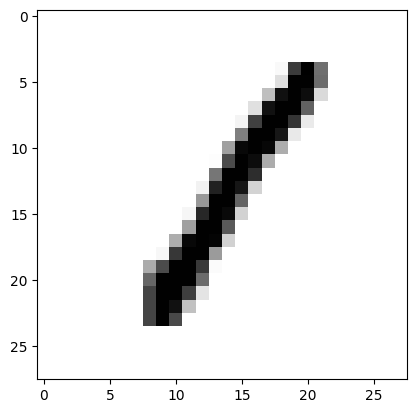

In [193]:
plt.imshow(images[3].numpy().squeeze(), cmap='gray_r')

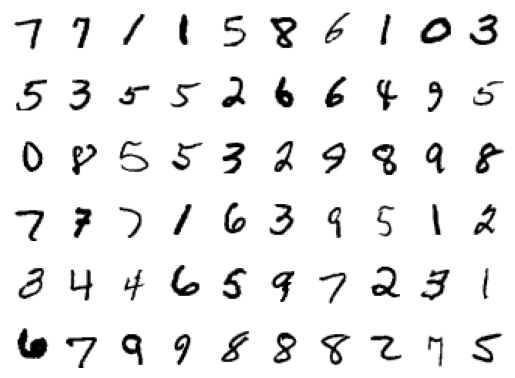

In [194]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [195]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, 128),
                      nn.ReLU(),
                      nn.Linear(128, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)


In [196]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [197]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0009, -0.0009, -0.0009,  ..., -0.0009, -0.0009, -0.0009],
        [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0007, -0.0007, -0.0007,  ..., -0.0007, -0.0007, -0.0007],
        [-0.0007, -0.0007, -0.0007,  ..., -0.0007, -0.0007, -0.0007],
        [-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003]])


In [198]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.5179137605895747
Epoch 1 - Training loss: 0.17637850556459064
Epoch 2 - Training loss: 0.13154371366647483
Epoch 3 - Training loss: 0.10404775273461919
Epoch 4 - Training loss: 0.08726059737032466
Epoch 5 - Training loss: 0.0767198190168003
Epoch 6 - Training loss: 0.06925709029512682
Epoch 7 - Training loss: 0.05801589818108382
Epoch 8 - Training loss: 0.051531663278181324
Epoch 9 - Training loss: 0.04739411801610118
Epoch 10 - Training loss: 0.04159312498568843
Epoch 11 - Training loss: 0.03685563379360774
Epoch 12 - Training loss: 0.03492919798884074
Epoch 13 - Training loss: 0.028704104514649588
Epoch 14 - Training loss: 0.02629586914144675

Training Time (in minutes) = 2.357279658317566


In [199]:
def out(model, images):
    images = images.view(images.shape[0], -1)
    output = model(images)
    top_p, top_class = output.topk(1, dim=1)
    return top_p, top_class

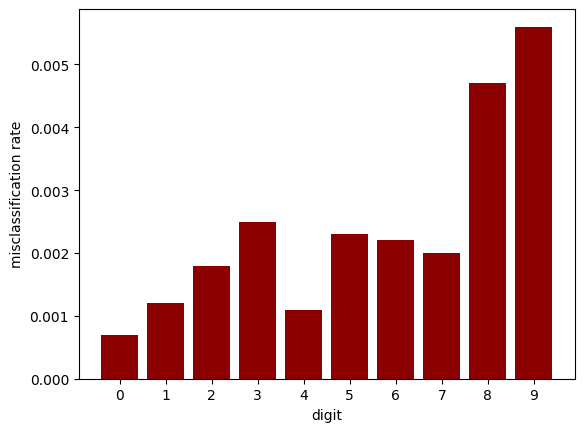

In [200]:
# test and plot misclassification rate for each number in the test set
# all on the same plot
def plot_misclassifications(model, testloader):
    misclassifications = np.zeros(10)
    for images, labels in testloader:
        top_p, top_class = out(model, images)
        equals = top_class == labels.view(*top_class.shape)
        for i in range(len(labels)):
            if not equals[i]:
                misclassifications[labels[i]] += 1
    misclassifications = misclassifications / len(testloader.dataset)
    #plt.plot(misclassifications)
    plt.bar(np.arange(10), misclassifications, color='darkred')
    
    plt.xticks(np.arange(10))
    plt.xlabel('digit')
    plt.ylabel('misclassification rate')
    plt.show()

plot_misclassifications(model, valloader)

In [201]:
# function that calculates the confusion matrix
# make the elements integers
# also print the digits on the axes
# label the rows as the true digit
# label the columns as the predicted digit
def confusion_matrix_print(model, testloader):
    confusion_matrix = np.zeros((10,10))
    for images, labels in testloader:
        top_p, top_class = out(model, images)
        for i in range(len(labels)):
            confusion_matrix[labels[i], top_class[i]] += 1
    confusion_matrix = confusion_matrix.astype(int)
    print('    0   1   2   3   4   5   6   7   8   9')
    for i in range(10):
        print(i, confusion_matrix[i])
        
        
confusion_matrix_print(model, valloader)

    0   1   2   3   4   5   6   7   8   9
0 [973   0   2   0   0   1   1   1   2   0]
1 [   0 1123    2    2    0    2    3    2    1    0]
2 [   5    1 1014    2    1    0    1    4    4    0]
3 [  1   0   8 985   1   4   0   6   2   3]
4 [  0   0   7   0 971   0   1   3   0   0]
5 [  3   0   0  11   2 869   5   0   0   2]
6 [  4   2   4   0   8   4 936   0   0   0]
7 [   1    1    8    1    1    2    0 1008    0    6]
8 [  3   0   7   9   4  10   7   3 927   4]
9 [  2   2   1   4  35   7   0   4   1 953]


In [202]:
def error(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            top_p, top_class = out(model, images)
            equals = top_class == labels.view(*top_class.shape)
            correct += torch.sum(equals.type(torch.FloatTensor))
            total += labels.size(0)
    print('Error: ', (1-float(correct/total))*100, '%')

error(model, valloader)

Error:  2.4100005626678467 %
